In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from scipy.optimize import leastsq , curve_fit
from scipy.signal import find_peaks
#from lmfit.models import ExponentialModel, GaussianModel,LorentzianModel, QuadraticModel

In [2]:
pl= pd.read_excel('pl.xlsx')
pl.dropna(axis=1, how='all',inplace=True)
pl.dropna(axis=0, how='any',inplace=True)
pl=pl.copy().rename(columns={'Unnamed: 0': 'wavelength'})


In [3]:
#x
x=(((pl.iloc[:,0:1]).to_numpy()).flatten())

#y
#sample1
y1=(((pl.iloc[:,1:2]).to_numpy()).flatten())
#sample2
y2=(((pl.iloc[:,2:3]).to_numpy()).flatten())
#sample3
y3=(((pl.iloc[:,3:4]).to_numpy()).flatten())
#sample4
y4=(((pl.iloc[:,4:5]).to_numpy()).flatten())
#sample5
y5=(((pl.iloc[:,5:6]).to_numpy()).flatten())


# curve fitting

##1

In [ ]:
def lorentzian(x, x0, a, gam):
    return a * gam**2 / (gam**2 + (x - x0)**2)

def multi_lorentz(x, params):
    off = params[0]
    paramsRest = params[1:]
    assert not (len(paramsRest) % 3)
    return off + sum([lorentzian(x, *paramsRest[i : i + 3]) for i in range(0, len(paramsRest), 3)])

def res_multi_lorentz(params, xData, yData):
    diff = [multi_lorentz(x, params) - y for x, y in zip(xData, yData)]
    return diff

def fit(x, y):
    y0 = y
    yData = y
    xData = x

    yGround = min(yData)
    yData = yData - yGround
    yAmp = max(yData)
    yData = yData / yAmp

    # initial properties of peaks
    pk, properties = find_peaks(yData, height=0.05, width=3)
    # extract peak heights and FWHM
    I = properties['peak_heights']
    fwhm = properties['widths']

    guess = [0]

    for i in range(len(pk)):
        guess.append(pk[i])
        guess.append(I[i])
        guess.append(fwhm[i])

    guess = np.array(guess)

    popt, pcov = leastsq(res_multi_lorentz, x0=guess, args=(xData, yData), maxfev=20000)

    testData = [multi_lorentz(x, popt) for x in xData]
    fitData = [yGround + yAmp * multi_lorentz(x, popt) for x in xData]

    # plot
    #ax is used for the first subplot displaying the original data, peaks, and the test data. bx is used for the second subplot displaying the original data and the fitted data.

    fig = plt.figure(figsize=(8, 5))

    #ax = fig.add_subplot(2, 1, 1)
    #ax.plot(pk, yData[pk], 'o', ms=5)
    #ax.plot(xData, yData, 'ok', ms=1)
    #ax.plot(xData, testData, 'r--', lw=1.5)

    bx = fig.add_subplot(2, 1, 2)

    bx.plot(xData, y0, ls='', marker='o', markersize=2, label='Original Data')
    bx.plot(xData, fitData, label='Fitted Data')
    bx.legend()  # Add legend to the plot
    plt.show()

    # Find peaks in the fitted data
    pk_fit, properties_fit = find_peaks(fitData, height=0.05, width=3)

    # Extract peak heights and FWHM from the fitted data
    I_fit = properties_fit['peak_heights']
    fwhm_fit = properties_fit['widths']

    # Extract peak positions from the fitted data
    peak_positions_fit = xData[pk_fit]


    # Create a DataFrame from the results
    res_df= pd.DataFrame({
        'amplitude': I_fit,
        'fwhm': fwhm_fit,
        'peak_positions': peak_positions_fit
    })
    # Set the index to 'peak 1' and 'peak 2'
    res_df.index = ['peak 1', 'peak 2']


    return res_df

##2

In [16]:
def lorentzian(x, x0, a, gam):
    return a * gam**2 / (gam**2 + (x - x0)**2)

def multi_lorentz(x, params):
    off = params[0]
    paramsRest = params[1:]
    assert not (len(paramsRest) % 3)
    return off + sum([lorentzian(x, *paramsRest[i : i + 3]) for i in range(0, len(paramsRest), 3)])

def res_multi_lorentz(params, xData, yData):
    diff = [multi_lorentz(x, params) - y for x, y in zip(xData, yData)]
    return diff

def fit(x, y, output_file=None):
    y0 = y
    yData = y
    xData = x

    yGround = min(yData)
    yData = yData - yGround
    yAmp = max(yData)
    yData = yData / yAmp

    # initial properties of peaks
    pk, properties = find_peaks(yData, height=0.05, width=3)
    # extract peak heights and FWHM
    I = properties['peak_heights']
    fwhm = properties['widths']

    guess = [0]

    for i in range(len(pk)):
        guess.append(pk[i])
        guess.append(I[i])
        guess.append(fwhm[i])

    guess = np.array(guess)

    popt, pcov = leastsq(res_multi_lorentz, x0=guess, args=(xData, yData), maxfev=20000)

    testData = [multi_lorentz(x, popt) for x in xData]
    fitData = [yGround + yAmp * multi_lorentz(x, popt) for x in xData]

    # plot
    fig, ax = plt.subplots(figsize=(8, 5))

    ax.plot(xData, y0, ls='', marker='o', markersize=2, label='Original Data')
    ax.plot(xData, fitData, label='Fitted Data')

    # Find peaks in the fitted data
    pk_fit, properties_fit = find_peaks(fitData, height=0.05, width=3)

    # Extract peak heights and FWHM from the fitted data
    I_fit = properties_fit['peak_heights']
    fwhm_fit = properties_fit['widths']

    # Extract peak positions from the fitted data
    peak_positions_fit = xData[pk_fit]

    #  vertical lines at peak positions
    for i, pos in enumerate(peak_positions_fit, start=1):
        ax.axvline(x=pos, color='r' if i % 2 == 0 else 'g', linestyle='--', label=f'Peak {i} Position')

    ax.legend()

    if output_file:
        plt.savefig(output_file, dpi=300)
        plt.close()
    else:
        plt.show()

    # DataFrame from the results
    res_df= pd.DataFrame({
        'amplitude': I_fit,
        'fwhm': fwhm_fit,
        'peak_positions': peak_positions_fit
    })
    # Set the index to 'peak 1' and 'peak 2'
    res_df.index = [f'peak {i}' for i in range(1, len(pk_fit) + 1)]

    return res_df


#sample1

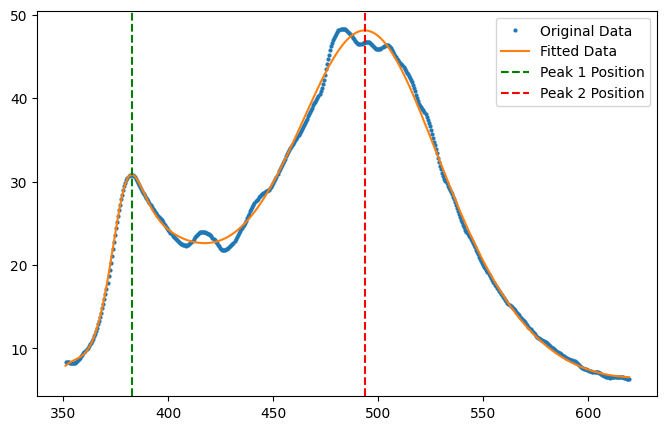

,amplitude,fwhm,peak_positions
peak 1,30.832324,30.836201,382.5
peak 2,48.126201,181.522977,493.5


In [17]:
fit(x, y1)

##1

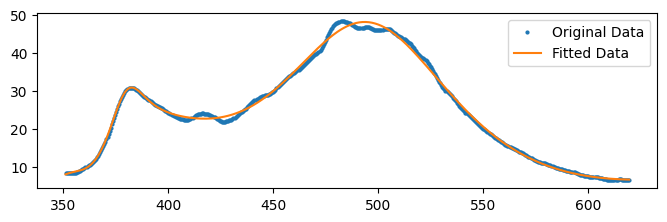

,amplitude,fwhm,peak_positions
peak 1,30.832324,30.836201,382.5
peak 2,48.126201,181.522977,493.5


In [ ]:
fit(x,y1)

#sample2

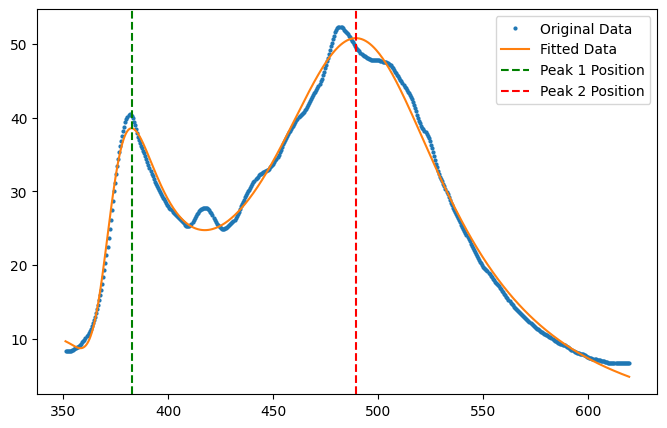

,amplitude,fwhm,peak_positions
peak 1,38.559226,40.989804,382.5
peak 2,50.792706,185.186280,489.5


In [18]:
fit(x,y2)

##1

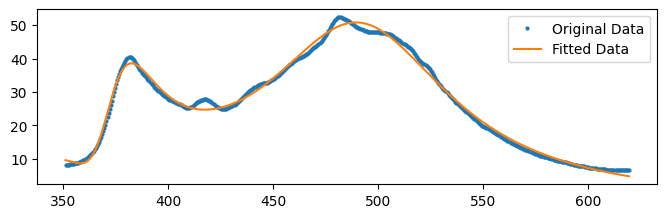

,amplitude,fwhm,peak_positions
peak 1,38.559226,40.989804,382.5
peak 2,50.792706,185.186280,489.5


In [ ]:
fit(x,y2)

#sample3

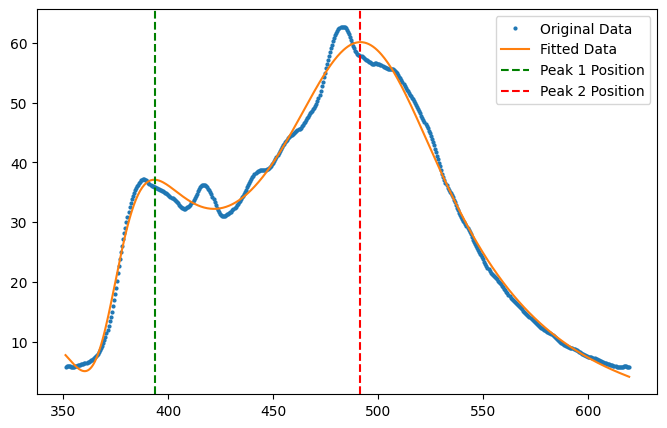

,amplitude,fwhm,peak_positions
peak 1,37.104766,39.657615,393.5
peak 2,60.128288,219.919341,491.5


In [19]:
fit(x,y3)

##1

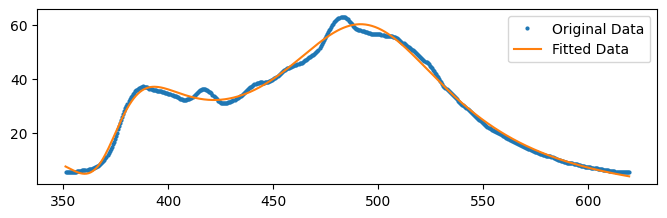

,amplitude,fwhm,peak_positions
peak 1,37.104766,39.657615,393.5
peak 2,60.128288,219.919341,491.5


In [12]:
fit(x,y3)

#sample4

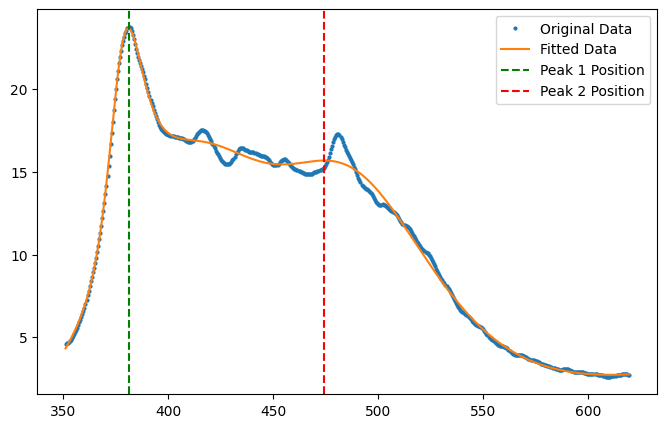

,amplitude,fwhm,peak_positions
peak 1,23.675676,257.255051,381.0
peak 2,15.684554,34.049933,474.0


In [20]:
fit(x,y4)

##1

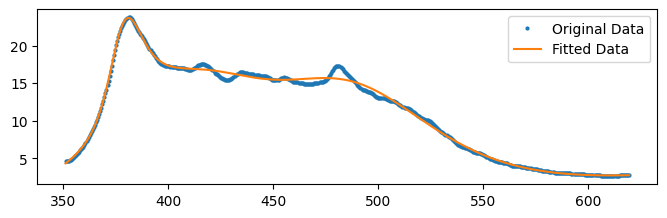

,amplitude,fwhm,peak_positions
peak 1,23.675676,257.255051,381.0
peak 2,15.684554,34.049933,474.0


In [ ]:
fit(x,y4)

#sample5

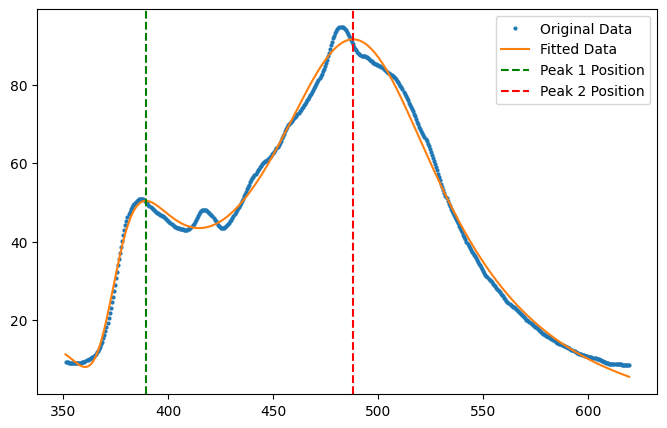

,amplitude,fwhm,peak_positions
peak 1,50.412122,34.700033,389.5
peak 2,91.623829,198.728952,488.0


In [21]:
fit(x,y5)

##1

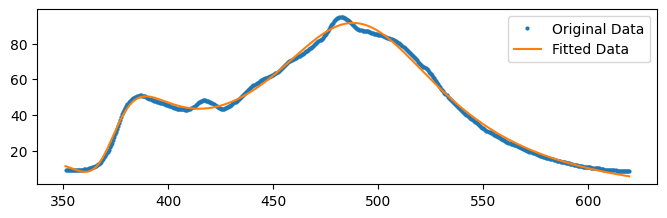

,amplitude,fwhm,peak_positions
peak 1,50.412122,34.700033,389.5
peak 2,91.623829,198.728952,488.0


In [ ]:
fit(x,y5)

#Bandgap calculation

In [ ]:
import pandas as pd

def calculate_bandgap(wavelength_nm):
    # Constants
    h = 6.626e-34  # Planck's constant in J·s
    c = 3.00e8    # Speed of light in m/s

    # Convert wavelength to meters
    wavelength_m = wavelength_nm * 1e-9

    # Calculate bandgap energy in joules
    bandgap_energy_J = h * c / wavelength_m

    # Convert bandgap energy to electron volts
    bandgap_energy_eV = bandgap_energy_J / (1.602e-19)  # 1 eV = 1.602e-19 J

    return bandgap_energy_eV

# Input wavelengths in nanometers
wavelengths = [382.5, 382.5, 393.5, 381.0, 389.5]

# Calculate bandgap energies for each wavelength
bandgap_energies = [calculate_bandgap(wavelength) for wavelength in wavelengths]

# Create a DataFrame
df = pd.DataFrame({
    'Wavelength (nm)': wavelengths,
    'Bandgap Energy (eV)': bandgap_energies
})

# Print the DataFrame
df

,Wavelength (nm),Bandgap Energy (eV)
0,382.5,3.243984
1,382.5,3.243984
2,393.5,3.153301
3,381.0,3.256756
4,389.5,3.185684
